In [ ]:
from radas import run_experiment, get_ray_results_dir
import ray.tune as tune
from v10_1 import trainable
import torch


results = await run_experiment(
    user_name="mengfan",
    experiment_name="复现论文2",
    param_space=dict(
        seed = tune.grid_search([0, 1, 2, 3, 4, 5, 6, 7, 8, 9]),

    ),
    # IMPORTANT: when using cluster, your trainable cannot be defined in this script, but has to be defined in a separate file, and imported in this script
    trainable=trainable,
    # When use cluster, local_storage_path needs to be specified in this way
    local_storage_path=get_ray_results_dir(),
    # Specify the cluster to use
    run_with="cluster:atol-gpu-5090",
    # Specify gram per trial
    cpu_per_trial=1,
    # If the gram_per_trial you set is larger than GRAM of a single GPU, you will be allocated with more than one GPUs
    # to fit your need. But in this case, you will need to handle how do you want to distribute your workload to these multiple GPUs
    # To check GRAM of a single GPU, use the following code:
    # from radas.clusters import gram_per_gpu
    #
    runtime_env={
        "pip": ["emoji","scikit-learn"],
        # for more runtime_env specifications, see https://docs.ray.io/en/latest/ray-core/handling-dependencies.html#api-reference
    },
    #
    instant_gpu_allocation=1,
)

[INFO]: Checking if the experiment exists...
[Choices]: Choose an option by number:
[1]: run -- Run a new experiment (if there is a running experiment, it will be stopped; if there is a existing experiment in the storage, it will be removed)
 2 : attach -- Attach to a running experiment
 3 : stop_attach -- Stop and attach to a running experiment
>>> [1]: Run a new experiment (if there is a running experiment, it will be stopped; if there is a existing experiment in the storage, it will be removed)
[INFO]: 🚀 正在测试代理连接...
[INFO]: ✅ 代理连接成功


2025-12-24 17:51:27,334	INFO dashboard_sdk.py:355 -- Uploading package gcs://_ray_pkg_6cd4a2ea76b8edf6.zip.
2025-12-24 17:51:27,335	INFO packaging.py:588 -- Creating a file package for local module '/mnt/data/home/mengfan/projects/BiPCN/BiPCN/v10'.
2025-12-24 17:51:27,379	INFO dashboard_sdk.py:355 -- Uploading package gcs://_ray_pkg_4588c91f8f921f3a.zip.
2025-12-24 17:51:27,380	INFO packaging.py:588 -- Creating a file package for local module '/mnt/data/home/mengfan/repos/radas/radas/'.


[INFO]: Submitting job...
[INFO]: Job submitted.
[INFO]: Tailing experiment logs below 👇👇👇
2025-12-24 04:51:27,421	INFO job_manager.py:531 -- Runtime env is setting up.
2025-12-24 04:51:40,325	INFO worker.py:1627 -- Using address 10.11.0.20:6379 set in the environment variable RAY_ADDRESS
2025-12-24 04:51:40,329	INFO worker.py:1768 -- Connecting to existing Ray cluster at address: 10.11.0.20:6379...
2025-12-24 04:51:40,348	INFO worker.py:1939 -- Connected to Ray cluster. View the dashboard at http://10.11.0.20:8265 
2025-12-24 04:51:40,377	INFO tune.py:253 -- Initializing Ray automatically. For cluster usage or custom Ray initialization, call `ray.init(...)` before `Tuner(...)`.
2025-12-24 04:51:40,411	WARNING tune_controller.py:2132 -- The maximum number of pending trials has been automatically set to the number of available cluster CPUs, which is high (281 CPUs/pending trials). If you're running an experiment with a large number of trials, this could lead to scheduling overhead. In t

In [3]:
results["df"]

,device,torch.cuda.is_available,config/seed,config/batch_size,config/epochs,config/layers,config/activation,config/last_send_activation,config/steps_train,config/steps_test,...,epoch_24/test_acc,epoch_24/E_test_after_infer,epoch_25/E_train_after_infer,epoch_25/test_acc,epoch_25/E_test_after_infer,final/test_acc,final/E_train_after_infer,final/E_test_after_infer,training_iteration,config/experiment_name
0,cuda,True,4,256,25,"[784, 256, 256, 10]",leaky_relu,identity,8,100,...,0.9673,0.010577,0.024952,0.9671,0.010330,0.9671,0.024952,0.010330,1,复现论文2
1,cuda,True,6,256,25,"[784, 256, 256, 10]",leaky_relu,identity,8,100,...,0.9670,0.010386,0.024742,0.9675,0.010109,0.9675,0.024742,0.010109,1,复现论文2
2,cuda,True,1,256,25,"[784, 256, 256, 10]",leaky_relu,identity,8,100,...,0.9670,0.010784,0.024948,0.9681,0.010514,0.9681,0.024948,0.010514,1,复现论文2
3,cuda,True,9,256,25,"[784, 256, 256, 10]",leaky_relu,identity,8,100,...,0.9678,0.011003,0.025403,0.9681,0.010723,0.9681,0.025403,0.010723,1,复现论文2
4,cuda,True,3,256,25,"[784, 256, 256, 10]",leaky_relu,identity,8,100,...,0.9661,0.010476,0.024594,0.9670,0.010061,0.9670,0.024594,0.010061,1,复现论文2
5,cuda,True,5,256,25,"[784, 256, 256, 10]",leaky_relu,identity,8,100,...,0.9706,0.010291,0.024171,0.9716,0.009877,0.9716,0.024171,0.009877,1,复现论文2
6,cuda,True,7,256,25,"[784, 256, 256, 10]",leaky_relu,identity,8,100,...,0.9682,0.009708,0.022908,0.9688,0.009319,0.9688,0.022908,0.009319,1,复现论文2
7,cuda,True,2,256,25,"[784, 256, 256, 10]",leaky_relu,identity,8,100,...,0.9670,0.009777,0.022783,0.9678,0.009501,0.9678,0.022783,0.009501,1,复现论文2
8,cuda,True,8,256,25,"[784, 256, 256, 10]",leaky_relu,identity,8,100,...,0.9685,0.010031,0.023186,0.9683,0.009661,0.9683,0.023186,0.009661,1,复现论文2
9,cuda,True,0,256,25,"[784, 256, 256, 10]",leaky_relu,identity,8,100,...,0.9659,0.009780,0.023111,0.9676,0.009420,0.9676,0.023111,0.009420,1,复现论文2


Available epoch metrics: ['E_test_after_infer', 'E_train_after_infer', 'test_acc']
Best seed = 5


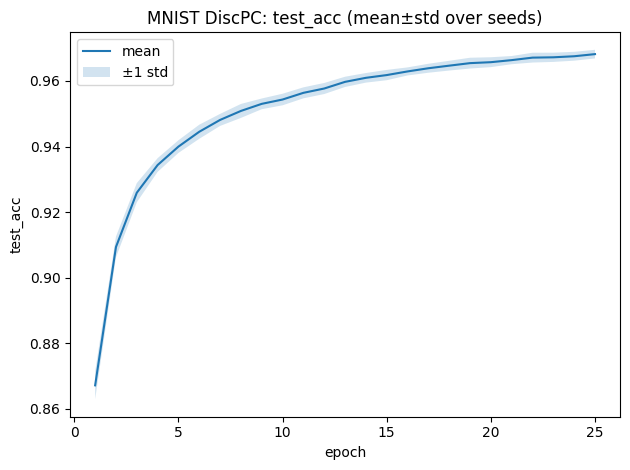

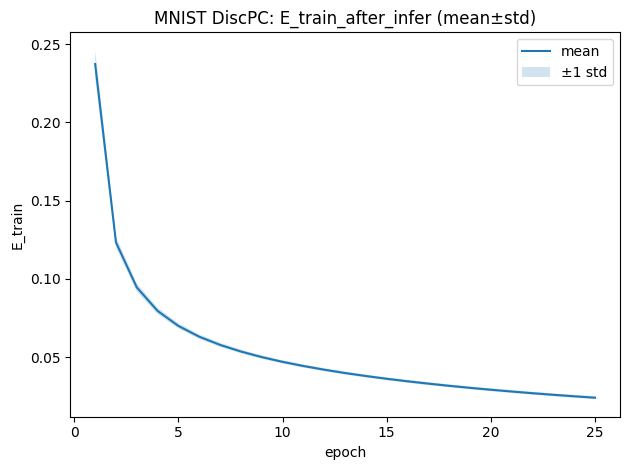

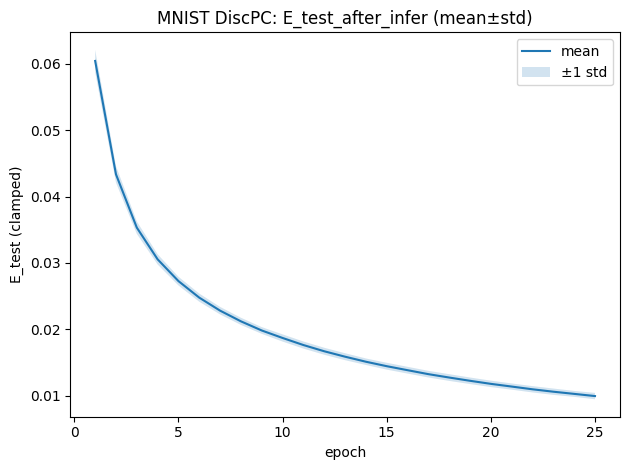

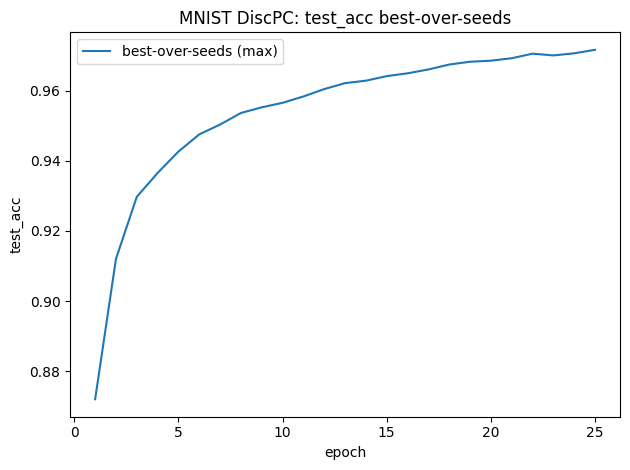

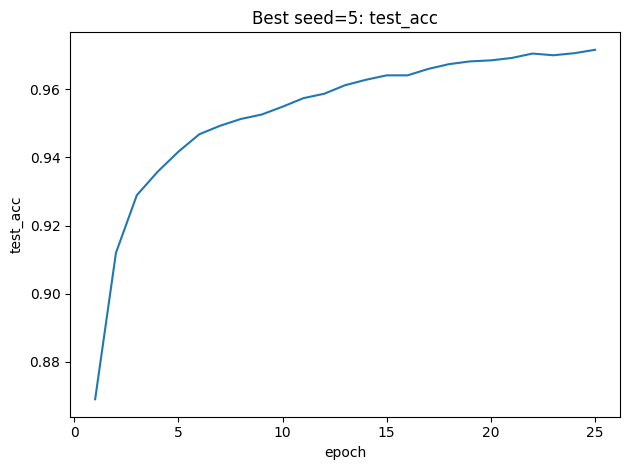

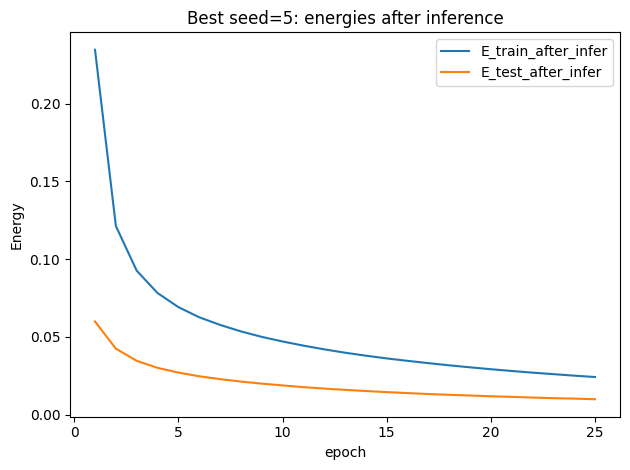

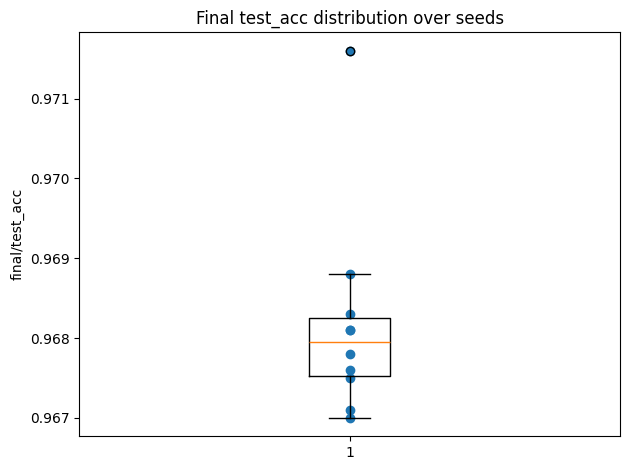

In [5]:
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

df = results["df"]  # 你已有

# -------------------------
# Utils
# -------------------------
def list_epoch_metrics(df: pd.DataFrame):
    """扫描 df 列名，找出所有 epoch_k/<metric> 的 metric 名称集合。"""
    pat = re.compile(r"^epoch_(\d+)/(.*)$")
    metrics = set()
    for c in df.columns:
        m = pat.match(c)
        if m:
            metrics.add(m.group(2))
    return sorted(metrics)

def _extract_epoch_series(df: pd.DataFrame, metric: str, seed_col="config/seed"):
    """
    wide -> long
    return: long_df columns [seed, epoch, value]
    """
    pat = re.compile(rf"^epoch_(\d+)/{re.escape(metric)}$")
    cols, epochs = [], []
    for c in df.columns:
        m = pat.match(c)
        if m:
            cols.append(c)
            epochs.append(int(m.group(1)))

    if not cols:
        raise ValueError(f"No columns for metric='{metric}'. Expected epoch_k/{metric}")

    order = np.argsort(epochs)
    cols = [cols[i] for i in order]
    epochs = [epochs[i] for i in order]

    out = df[[seed_col] + cols].copy()
    out = out.melt(id_vars=[seed_col], var_name="col", value_name="value")
    out["epoch"] = out["col"].str.extract(r"epoch_(\d+)/")[0].astype(int)
    out = out.drop(columns=["col"]).rename(columns={seed_col: "seed"})
    out["value"] = pd.to_numeric(out["value"], errors="coerce")
    out = out.sort_values(["seed", "epoch"]).reset_index(drop=True)
    return out

def _mean_std_over_seeds(long_df: pd.DataFrame):
    g = long_df.groupby("epoch")["value"]
    stat = pd.DataFrame({"epoch": g.mean().index, "mean": g.mean().values, "std": g.std(ddof=1).values})
    return stat

def best_seed(df: pd.DataFrame, key="final/test_acc", seed_col="config/seed"):
    idx = pd.to_numeric(df[key], errors="coerce").idxmax()
    return int(df.loc[idx, seed_col])

# -------------------------
# Plot helpers
# -------------------------
def plot_mean_curve(df: pd.DataFrame, metric: str, title=None, ylabel=None, show_std=True):
    long_df = _extract_epoch_series(df, metric)
    stat = _mean_std_over_seeds(long_df)

    plt.figure()
    plt.plot(stat["epoch"], stat["mean"], label="mean")
    if show_std:
        lo = stat["mean"] - stat["std"]
        hi = stat["mean"] + stat["std"]
        plt.fill_between(stat["epoch"], lo, hi, alpha=0.2, label="±1 std")

    plt.xlabel("epoch")
    plt.ylabel(ylabel or metric)
    plt.title(title or f"Mean over seeds: {metric}")
    plt.legend()
    plt.tight_layout()
    return stat

def plot_best_seed_curve(df: pd.DataFrame, best_s: int, metric: str, title=None, ylabel=None):
    sub = df[df["config/seed"] == best_s].copy()
    assert len(sub) == 1, f"Expected exactly 1 row for seed={best_s}, got {len(sub)}"
    long_df = _extract_epoch_series(sub, metric)

    plt.figure()
    plt.plot(long_df["epoch"], long_df["value"])
    plt.xlabel("epoch")
    plt.ylabel(ylabel or metric)
    plt.title(title or f"Best seed={best_s}: {metric}")
    plt.tight_layout()
    return long_df

def plot_best_over_seeds(df: pd.DataFrame, metric: str, title=None, ylabel=None):
    """每个 epoch 取所有 seeds 的 max（常用于看“最优可达水平”）。"""
    long_df = _extract_epoch_series(df, metric)
    best = long_df.groupby("epoch")["value"].max().reset_index()

    plt.figure()
    plt.plot(best["epoch"], best["value"], label="best-over-seeds (max)")
    plt.xlabel("epoch")
    plt.ylabel(ylabel or metric)
    plt.title(title or f"Best-over-seeds: {metric}")
    plt.legend()
    plt.tight_layout()
    return best

def plot_final_distribution(df: pd.DataFrame, key="final/test_acc", title=None, ylabel=None):
    vals = pd.to_numeric(df[key], errors="coerce").dropna().values

    plt.figure()
    plt.boxplot(vals, vert=True)
    plt.scatter(np.ones_like(vals), vals)  # 不加 jitter 也行
    plt.ylabel(ylabel or key)
    plt.title(title or f"Distribution over seeds: {key}")
    plt.tight_layout()
    return vals

# -------------------------
# Main: 推荐你直接出图的组合
# -------------------------
print("Available epoch metrics:", list_epoch_metrics(df))

# 1) 核心：test_acc 的 mean±std
plot_mean_curve(df, "test_acc", title="MNIST DiscPC: test_acc (mean±std over seeds)", ylabel="test_acc", show_std=True)

# 2) 能量曲线：mean±std（更贴近论文里监控推断收敛/能量尺度）
plot_mean_curve(df, "E_train_after_infer", title="MNIST DiscPC: E_train_after_infer (mean±std)", ylabel="E_train", show_std=True)
plot_mean_curve(df, "E_test_after_infer",  title="MNIST DiscPC: E_test_after_infer (mean±std)",  ylabel="E_test (clamped)", show_std=True)

# 3) 每个 epoch 的 best-over-seeds（max）
plot_best_over_seeds(df, "test_acc", title="MNIST DiscPC: test_acc best-over-seeds", ylabel="test_acc")

# 4) best seed 的曲线（用 final/test_acc 最大的那行）
best_s = best_seed(df, key="final/test_acc")
print("Best seed =", best_s)

plot_best_seed_curve(df, best_s, "test_acc", title=f"Best seed={best_s}: test_acc", ylabel="test_acc")

# 能量建议放一张图里对比（同量纲，读起来直观）
best_E_train = _extract_epoch_series(df[df["config/seed"] == best_s], "E_train_after_infer")
best_E_test  = _extract_epoch_series(df[df["config/seed"] == best_s], "E_test_after_infer")

plt.figure()
plt.plot(best_E_train["epoch"], best_E_train["value"], label="E_train_after_infer")
plt.plot(best_E_test["epoch"],  best_E_test["value"],  label="E_test_after_infer")
plt.xlabel("epoch")
plt.ylabel("Energy")
plt.title(f"Best seed={best_s}: energies after inference")
plt.legend()
plt.tight_layout()

# 5) final/test_acc 分布（箱线+散点）
plot_final_distribution(df, key="final/test_acc", title="Final test_acc distribution over seeds", ylabel="final/test_acc")

plt.show()
